## Analysis and Plots

#### Libraries

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.path as mpath
import matplotlib.patches as patches
import matplotlib.cm as cm
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import cartopy.mpl.gridliner as gridliner
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore", message="All-NaN slice encountered")
%matplotlib inline
import time
import cftime
import seaborn as sns

In [2]:
start_time=time.time()

path = '/storage2/tkyeimiah'


aice_dh = xr.open_dataset(path+'/iHESP/EM1/hist/aice_hist/aice_hist.nc')
aice_dp = xr.open_dataset(path+'/iHESP/EM1/proj/aice_proj/aice_proj.nc')


hi_dh = xr.open_dataset(path+'/iHESP/EM1/hist/hi_hist/hi_hist.nc')
hi_dp = xr.open_dataset(path+'/iHESP/EM1/proj/hi_proj/hi_proj.nc')


end_time=time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)

print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

Execution time:  0.0 hours, 0.0 minutes, 0.09792017936706543 seconds


In [3]:
def shift_month(ds):
    ds = ds.copy()  
    # Convert each cftime.DatetimeNoLeap to pandas datetime
    time_as_pd_datetime = [pd.Timestamp(date.year, date.month, date.day) for date in ds['time'].values]

    # Subtract one month
    time_as_pd_datetime = [date - pd.DateOffset(months=1) for date in time_as_pd_datetime]

    # Convert back to cftime.DatetimeNoLeap
    time_as_cftime = [cftime.DatetimeNoLeap(date.year, date.month, date.day) for date in time_as_pd_datetime]

    # Replace the time coordinate in the dataset
    ds['time'] = time_as_cftime
    
    return ds

### HR-CESM

In [4]:
aice_hist=shift_month(aice_dh['aice'])
aice_proj=shift_month(aice_dp['aice'])

tarea_hist=aice_dh['uarea']
tarea_proj=aice_dp['uarea']

In [5]:
# Define the Labrador coast boundaries (replace these with your desired region)
lon_min, lon_max =287, 315 #73W & 45W
lat_min, lat_max =51,69


# Create a mask for Labrador coast 
mask_hist = ((aice_hist.TLAT >= lat_min) & (aice_hist.TLAT <= lat_max) &
        (aice_hist.TLON >= lon_min) & (aice_hist.TLON <= lon_max))

mask_hist2 = ((tarea_hist.TLAT >= lat_min) & (tarea_hist.TLAT <= lat_max) &
        (tarea_hist.TLON >= lon_min) & (tarea_hist.TLON <= lon_max))

mask_proj = ((aice_proj.TLAT >= lat_min) & (aice_proj.TLAT <= lat_max) &
        (aice_proj.TLON >= lon_min) & (aice_proj.TLON <= lon_max))

mask_proj2 = ((tarea_proj.TLAT >= lat_min) & (tarea_proj.TLAT <= lat_max) &
        (tarea_proj.TLON >= lon_min) & (tarea_proj.TLON <= lon_max))

# Apply the mask to the aice variable
aice_hist_region_ =aice_hist.where(mask_hist, drop=True)
tarea_hist_region_=tarea_hist.where(mask_hist2, drop=True)
aice_proj_region_ =aice_proj.where(mask_proj, drop=True)
tarea_proj_region_=tarea_proj.where(mask_proj2, drop=True)

#### SIE

In [6]:
sic_greater_15hist = xr.where(aice_hist_region_ >= 15, 1, 0)
sic_greater_15proj = xr.where(aice_proj_region_ >= 15, 1, 0)

aice_hist_region = (sic_greater_15hist * tarea_hist_region_)/1e12
aice_proj_region = (sic_greater_15proj * tarea_proj_region_)/1e12

In [7]:
#plot for article
model_1990_99 = aice_hist_region.sel(time=slice('1990-01-01','1999-12-31'))
model_2000_05 = aice_hist_region.sel(time=slice('2000-01-01','2005-12-31'))
model_2006_20 = aice_proj_region.sel(time=slice('2006-01-01','2020-12-31'))
model_2000_20 = xr.concat([model_2000_05, model_2006_20], dim='time')
model_2040_60 = aice_proj_region.sel(time=slice('2040-01-01','2060-12-31'))
model_2080_100= aice_proj_region.sel(time=slice('2080-01-01','2100-12-31'))

In [8]:
model_1990_99_monthly = model_1990_99.groupby('time.month').mean('time').sum(('nj','ni'))
model_2000_20_monthly = model_2000_20.groupby('time.month').mean('time').sum(('nj','ni'))

model_1990_99_monmax = model_1990_99.groupby('time.month').max('time').sum(('nj','ni'))
model_2000_20_monmax = model_2000_20.groupby('time.month').max('time').sum(('nj','ni'))

model_1990_99_monmin = model_1990_99.groupby('time.month').min('time').sum(('nj','ni'))
model_2000_20_monmin = model_2000_20.groupby('time.month').min('time').sum(('nj','ni'))

#### SIC

In [9]:
#plot for article
model_sic_1990_99 = aice_hist_region_.sel(time=slice('1990-01-01','1999-12-31'))
model_sic_2000_05 = aice_hist_region_.sel(time=slice('2000-01-01','2005-12-31'))
model_sic_2006_20 = aice_proj_region_.sel(time=slice('2006-01-01','2020-12-31'))
model_sic_2000_20 = xr.concat([model_sic_2000_05, model_sic_2006_20], dim='time')
model_sic_2040_60 = aice_proj_region_.sel(time=slice('2040-01-01','2060-12-31'))
model_sic_2080_100= aice_proj_region_.sel(time=slice('2080-01-01','2100-12-31'))

In [10]:
model_hist=aice_hist_region_.sel(time=slice('1990-01-01','2005-12-31'))
model_proj=aice_proj_region_.sel(time=slice('2006-01-01','2020-12-31'))
model_CT_sel= xr.concat([model_hist, model_proj], dim='time')

#### SIT

In [11]:
hi_hist=shift_month(hi_dh['hi'])
hi_proj=shift_month(hi_dp['hi'])

In [12]:
# Define the Labrador coast boundaries (replace these with your desired region)
lon_min, lon_max =287, 315 #73W & 45W
lat_min, lat_max =51,69

# Create a mask for Labrador coast 
mask_hist3 = ((hi_hist.TLAT >= lat_min) & (hi_hist.TLAT <= lat_max) &
              (hi_hist.TLON >= lon_min) & (hi_hist.TLON <= lon_max))


mask_proj3 = ((hi_proj.TLAT >= lat_min) & (hi_proj.TLAT <= lat_max) &
              (hi_proj.TLON >= lon_min) & (hi_proj.TLON <= lon_max))

# Apply the mask to the aice variable
hi_hist_region=hi_hist.where(mask_hist3, drop=True)
hi_proj_region=hi_proj.where(mask_proj3, drop=True)

In [13]:
#plot for article
model_hi_1990_99 = hi_hist_region.sel(time=slice('1990-01-01','1999-12-31'))
model_hi_2000_05 = hi_hist_region.sel(time=slice('2000-01-01','2005-12-31'))
model_hi_2006_20 = hi_proj_region.sel(time=slice('2006-01-01','2020-12-31'))
model_hi_2000_20 = xr.concat([model_hi_2000_05, model_hi_2006_20], dim='time')
model_hi_2040_60 = hi_proj_region.sel(time=slice('2040-01-01','2060-12-31'))
model_hi_2080_100= hi_proj_region.sel(time=slice('2080-01-01','2100-12-31'))

In [14]:
model_hi_1990_99_monthly = model_hi_1990_99.groupby('time.month').mean('time').mean(('nj','ni'))
model_hi_2000_20_monthly = model_hi_2000_20.groupby('time.month').mean('time').mean(('nj','ni'))

model_hi_1990_99_monmax = model_hi_1990_99.groupby('time.month').max('time').mean(('nj','ni'))
model_hi_2000_20_monmax = model_hi_2000_20.groupby('time.month').max('time').mean(('nj','ni'))

model_hi_1990_99_monmin = model_hi_1990_99.groupby('time.month').min('time').mean(('nj','ni'))
model_hi_2000_20_monmin = model_hi_2000_20.groupby('time.month').min('time').mean(('nj','ni'))

### CESM2-LE

In [15]:
start_time=time.time()

Cesm_lr=xr.open_dataset(path+'/CESM2-LE/aice/EM_1001.nc')

end_time=time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)

print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

Execution time:  0.0 hours, 0.0 minutes, 0.025347471237182617 seconds


In [16]:
aice_lr=shift_month(Cesm_lr['aice'])
tarea_lr=Cesm_lr['uarea']

In [17]:
# Define the Labrador coast boundaries (replace these with your desired region)
lon_min, lon_max =287, 315 #73W & 45W
lat_min, lat_max =51,69

# Create a mask for Labrador coast 
mask_lr = ((aice_lr.TLAT >= lat_min) & (aice_lr.TLAT <= lat_max) &
        (aice_lr.TLON >= lon_min) & (aice_lr.TLON <= lon_max))

mask_lr2 = ((tarea_lr.TLAT >= lat_min) & (tarea_lr.TLAT <= lat_max) &
        (tarea_lr.TLON >= lon_min) & (tarea_lr.TLON <= lon_max))

# Apply the mask to the aice variable
aice_lr_region_ =aice_lr.where(mask_lr, drop=True)
tarea_lr_region_=tarea_lr.where(mask_lr2, drop=True)

#### SIE

In [18]:
sic_greater_lr_15 = xr.where(aice_lr_region_ >= 0.15, 1, 0)
aice_lr_region = (sic_greater_lr_15 * tarea_lr_region_)/1e12

## CIS

In [19]:
start_time=time.time()

area=xr.open_dataset(path+'/Obs/CIS/CIS_processed/Area.nc')
obs=xr.open_dataset(path+'/Obs/CIS/CIS_combined/CT_all_combined.nc')
#obs1=xr.open_mfdataset(path+'/Obs/CIS/CIS_10km_yyyy/*.nc')
end_time=time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)

print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

Execution time:  0.0 hours, 0.0 minutes, 0.018893003463745117 seconds


In [20]:
obs

<xarray.Dataset>
Dimensions:  (rlon: 562, rlat: 498, time: 372)
Coordinates:
  * rlon     (rlon) float64 -28.05 -27.95 -27.85 -27.75 ... 27.85 27.95 28.05
  * rlat     (rlat) float64 -24.85 -24.75 -24.65 -24.55 ... 24.65 24.75 24.85
    lon      (rlat, rlon) float64 ...
    lat      (rlat, rlon) float64 ...
  * time     (time) datetime64[ns] 1990-01-31 1990-02-28 ... 2020-12-31
Data variables:
    CT       (time, rlat, rlon) float32 ...

In [21]:
#obs_CT=obs['CT']
obs_area=area['area']
obs_CT=obs['CT']

#### Applying the common continent

In [22]:
# Load the mask (binary array)
continent_mask = np.load('/storage2/tkyeimiah/biggestCommonContinent.npy') 

# Convert the mask to an xarray DataArray
mask_da = xr.DataArray(continent_mask, dims=['rlat', 'rlon']) 

In [23]:
# Apply the mask
CT1_resampled= obs_CT.where(mask_da == 0)

In [24]:
lat_min, lat_max = 51, 69
lon_min, lon_max =-73, -45 

# Create a mask for Labrador coast 
maskobs1 = ((obs_area.lat>= lat_min) & (obs_area.lat <= lat_max) & (obs_area.lon >= lon_min) & (obs_area.lon<= lon_max))
maskobs2 = ((CT1_resampled.lat>= lat_min) & (CT1_resampled.lat <= lat_max) & (CT1_resampled.lon >= lon_min) & (CT1_resampled.lon<= lon_max))

obs_CT_region =CT1_resampled.where(maskobs2, drop=True)
obs_area_region =obs_area.where(maskobs1, drop=True)

In [25]:
obs_CT_resampled=obs_CT_region

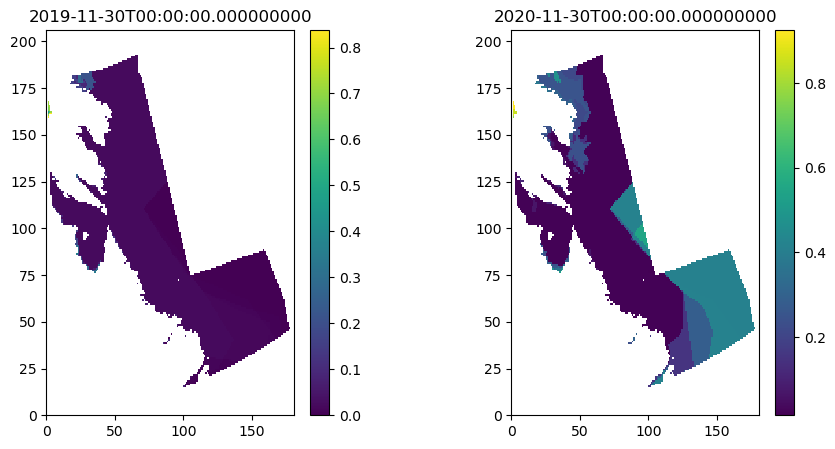

In [26]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
cb=ax[0].pcolormesh(obs_CT_resampled[358])
ax[0].set_title(str(obs_CT_resampled[358].coords['time'].values))
fig.colorbar(cb, ax=ax[0])

cb1=ax[1].pcolormesh(obs_CT_resampled[370])
ax[1].set_title(str(obs_CT_resampled[370].coords['time'].values))
fig.colorbar(cb1, ax=ax[1])

plt.subplots_adjust(wspace=0.5)


#### SIE

In [27]:
#replacing all ice 15 % and above with 1 and less with 0
obs_greater_15 = xr.where(obs_CT_resampled>= 0.15, 1, 0)

#calculating the SIE
obs_CT_region=(obs_greater_15 * obs_area_region)/1e6

In [28]:
#sel
cis_1990_99 = obs_CT_region.sel(time=slice('1990', '1999'))
cis_2000_20 = obs_CT_region.sel(time=slice('2000', '2020'))

In [29]:
cis_1990_99_monthly = cis_1990_99.groupby('time.month').mean('time').sum(['rlat','rlon'])
cis_2000_20_monthly = cis_2000_20.groupby('time.month').mean('time').sum(['rlat','rlon'])

In [30]:
obs_1990_99 = obs_CT_region.sel(time=slice('1990', '1999'))
obs_2000_09 = obs_CT_region.sel(time=slice('2000', '2009'))
obs_2010_20 = obs_CT_region.sel(time=slice('2010', '2020'))

In [31]:
obs_1990_99_monthly = obs_1990_99.groupby('time.month').mean('time').sum(['rlat','rlon'])
obs_2000_09_monthly = obs_2000_09.groupby('time.month').mean('time').sum(['rlat','rlon'])
obs_2010_20_monthly = obs_2010_20.groupby('time.month').mean('time').sum(['rlat','rlon'])

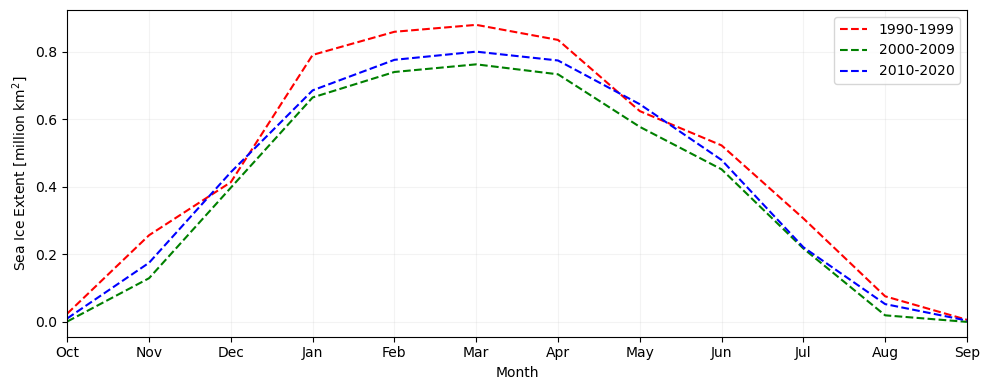

Execution time:  0.0 hours, 0.0 minutes, 0.28079795837402344 seconds


In [32]:
# Set xticks to represent months from January to December

start_time = time.time()

fig,ax=plt.subplots(figsize=(10,4))
#all_data = [ model_1990_99_monthly,model_2000_09_monthly, model_2010_19_monthly ]
all_data_a =[obs_1990_99_monthly, obs_2000_09_monthly ,obs_2010_20_monthly]
labels=['1990','2000','2010']


labels = ['1990-1999', '2000-2009', '2010-2020']

cmapp=['lime', 'darkgreen', 'salmon', 'cyan', 'magenta', 'yellow', 'coral', 'maroon', 
      'purple',  'navy', 'turquoise','beige', 'peachpuff', 'lightblue', 'red', 'green', 'blue',
      'gold', 'indigo', 'pink', 'olive','violet', 'brown', 'orange', 'black',]
colors=[cmapp[14], cmapp[15], cmapp[16]]

for i in range(len(all_data_a)):
    
    linestyle = '--'  # Default linestyle
    ax.plot(np.arange(12), np.append(all_data_a[i][9:],all_data_a[i][:9]), color=colors[i],  label=labels[i], linestyle=linestyle)
    

plt.xticks(np.arange(0,12), ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun',
                             'Jul','Aug','Sep'])
plt.legend()
plt.xlabel('Month')
plt.ylabel('Sea Ice Extent [million km$^2$]')
plt.grid(alpha=0.15)
plt.xlim(0,11)
plt.tight_layout()
#plt.savefig(path+'/plots/'+'plot1-new1.jpg', dpi=300, bbox_inches='tight')

plt.show()


end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

#### SIC

In [33]:
cis_sic_1990_99 = obs_CT_resampled.sel(time=slice('1990', '1999'))
cis_sic_2000_20 = obs_CT_resampled.sel(time=slice('2000', '2020'))

obs_CT_sel=obs_CT_resampled


### PLOT SECTION

### Fig 2

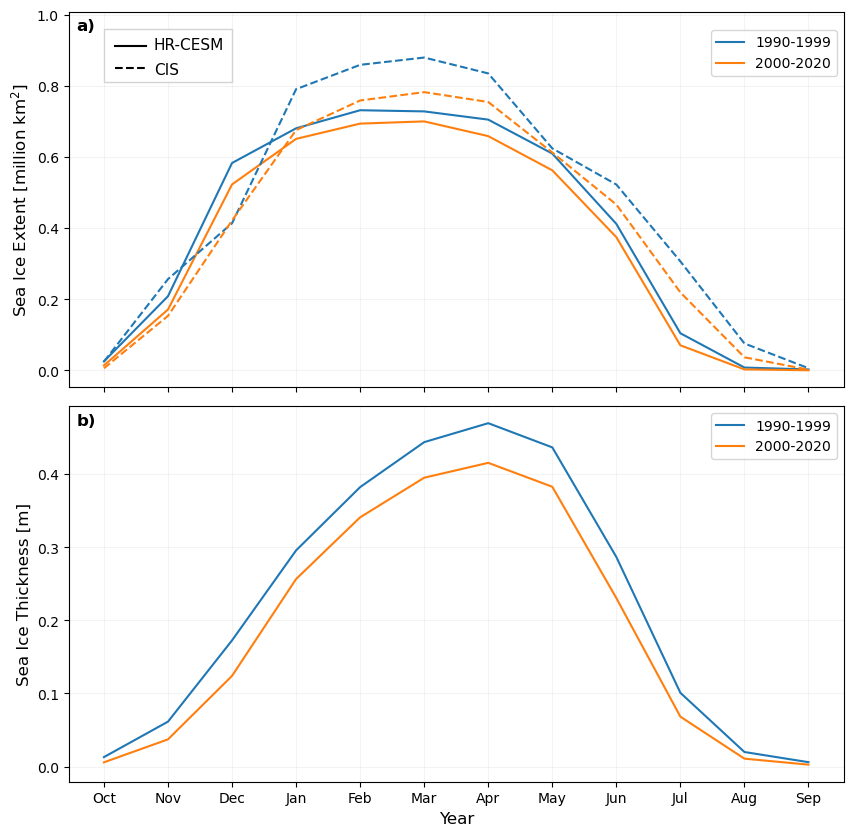

Execution time:  0.0 hours, 0.0 minutes, 1.1695685386657715 seconds


In [34]:
###article

start_time = time.time()
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

model_cis_dt = [model_1990_99_monthly, model_2000_20_monthly, cis_1990_99_monthly, cis_2000_20_monthly]

hi_dt =[model_hi_1990_99_monthly, model_hi_2000_20_monthly]


cl = ['tab:blue', 'tab:orange', 'tab:blue', 'tab:orange']
month_dt = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug', 'Sep']
lb = ['1990-1999', '2000-2020']

# First plot
for i in range (len(model_cis_dt)):
    if i <2:
        ls='-'
        ax[0].plot(month_dt, np.append(model_cis_dt[i][9:], model_cis_dt[i][:9]), linestyle=ls, color=cl[i], label=lb[i])
        #ax[0].fill_between(month_dt, np.append(mc_data_mn[i][9:],mc_data_mn[i][:9]),
                           #np.append(mc_data_mx[i][9:],mc_data_mx[i][:9]),color=cl[i], alpha=0.03)
        ax[0].legend(loc='upper right', bbox_to_anchor=(1.0,0.97))
        
    if i >=2:
        ls='--'
        ax[0].plot(month_dt, np.append(model_cis_dt[i][9:], model_cis_dt[i][:9]), linestyle=ls, color=cl[i])
        #ax[0].fill_between(month_dt, np.append(mc_data_mn[i][9:],mc_data_mn[i][:9]),
                           #np.append(mc_data_mx[i][9:],mc_data_mx[i][:9]),color=cl[i], alpha=0.03)
        
    ax[0].set_ylabel('Sea Ice Extent [million km$^2$]', fontsize=12)
    ax[0].grid(alpha=0.15)
    
                 
# Second plot  
for i in range (len(hi_dt)):
    ls='-'
    ax[1].plot(month_dt, np.append(hi_dt[i][9:], hi_dt[i][:9]), linestyle=ls, color=cl[i], label=lb[i])
    #ax[1].fill_between(month_dt, np.append(hi_data_mn[i][9:],hi_data_mn[i][:9]),np.append(hi_data_mx[i][9:],hi_data_mx[i][:9]),
                       #color=cl[i], alpha=0.03)
    ax[1].legend(loc='upper right')
    ax[1].set_ylabel('Sea Ice Thickness [m]', fontsize=12)
    ax[1].set_xlabel('Year', fontsize=12)
    ax[1].grid(alpha=0.15)  

rectangle = patches.Rectangle((0.005, 0.81), 2, 0.15, edgecolor='lightgray',  facecolor='white',linewidth=1, zorder=10)
ax[0].add_patch(rectangle)

# Add HR-CESM text and line
ax[0].text(0.11, 0.9, 'HR-CESM', transform=ax[0].transAxes, fontsize=11, zorder=11)
ax[0].plot([0.06, 0.1], [0.91, 0.91], color='black', transform=ax[0].transAxes, linestyle='-', zorder=11)

# Add CIS text and dashed line
ax[0].text(0.11, 0.835, 'CIS', transform=ax[0].transAxes, fontsize=11, zorder=11)
ax[0].plot([0.06, 0.1], [0.85, 0.85], color='black', transform=ax[0].transAxes, linestyle='--', zorder=11)

    
ax[0].text(0.01, 0.95, 'a)',transform=ax[0].transAxes, fontweight='bold', fontsize=12)
ax[1].text(0.01, 0.95, 'b)',transform=ax[1].transAxes, fontweight='bold', fontsize=12)


plt.subplots_adjust(hspace=0.05)
plt.savefig('/storage2/tkyeimiah/Plots/Fig2.jpg', dpi=500, bbox_inches='tight')
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

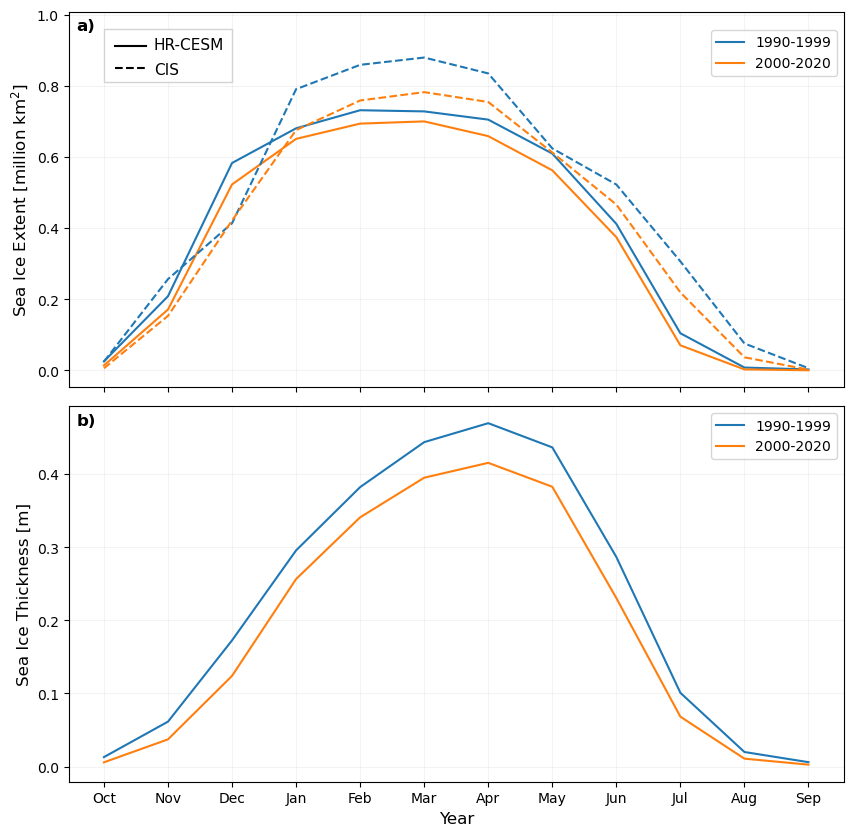

Execution time:  0.0 hours, 0.0 minutes, 1.0917415618896484 seconds


In [35]:
###article
start_time = time.time()
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

model_cis_dt = [model_1990_99_monthly, model_2000_20_monthly, cis_1990_99_monthly, cis_2000_20_monthly]

hi_dt =[model_hi_1990_99_monthly, model_hi_2000_20_monthly]


cl = ['tab:blue', 'tab:orange', 'tab:blue', 'tab:orange']
month_dt = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug', 'Sep']
lb = ['1990-1999', '2000-2020']

# First plot
for i in range (len(model_cis_dt)):
    if i <2:
        ls='-'
        ax[0].plot(month_dt, np.append(model_cis_dt[i][9:], model_cis_dt[i][:9]), linestyle=ls, color=cl[i], label=lb[i])
        #ax[0].fill_between(month_dt, np.append(mc_data_mn[i][9:],mc_data_mn[i][:9]),
                           #np.append(mc_data_mx[i][9:],mc_data_mx[i][:9]),color=cl[i], alpha=0.03)
        ax[0].legend(loc='upper right', bbox_to_anchor=(1.0,0.97))
        
    if i >=2:
        ls='--'
        ax[0].plot(month_dt, np.append(model_cis_dt[i][9:], model_cis_dt[i][:9]), linestyle=ls, color=cl[i])
        #ax[0].fill_between(month_dt, np.append(mc_data_mn[i][9:],mc_data_mn[i][:9]),
                           #np.append(mc_data_mx[i][9:],mc_data_mx[i][:9]),color=cl[i], alpha=0.03)
        
    ax[0].set_ylabel('Sea Ice Extent [million km$^2$]', fontsize=12)
    ax[0].grid(alpha=0.15)
    
                 
# Second plot  
for i in range (len(hi_dt)):
    ls='-'
    ax[1].plot(month_dt, np.append(hi_dt[i][9:], hi_dt[i][:9]), linestyle=ls, color=cl[i], label=lb[i])
    #ax[1].fill_between(month_dt, np.append(hi_data_mn[i][9:],hi_data_mn[i][:9]),np.append(hi_data_mx[i][9:],hi_data_mx[i][:9]),
                       #color=cl[i], alpha=0.03)
    ax[1].legend(loc='upper right')
    ax[1].set_ylabel('Sea Ice Thickness [m]', fontsize=12)
    ax[1].set_xlabel('Year', fontsize=12)
    ax[1].grid(alpha=0.15)  

rectangle = patches.Rectangle((0.005, 0.81), 2, 0.15, edgecolor='lightgray',  facecolor='white',linewidth=1, zorder=10)
ax[0].add_patch(rectangle)

# Add HR-CESM text and line
ax[0].text(0.11, 0.9, 'HR-CESM', transform=ax[0].transAxes, fontsize=11, zorder=11)
ax[0].plot([0.06, 0.1], [0.91, 0.91], color='black', transform=ax[0].transAxes, linestyle='-', zorder=11)

# Add CIS text and dashed line
ax[0].text(0.11, 0.835, 'CIS', transform=ax[0].transAxes, fontsize=11, zorder=11)
ax[0].plot([0.06, 0.1], [0.85, 0.85], color='black', transform=ax[0].transAxes, linestyle='--', zorder=11)

    
ax[0].text(0.01, 0.95, 'a)',transform=ax[0].transAxes, fontweight='bold', fontsize=12)
ax[1].text(0.01, 0.95, 'b)',transform=ax[1].transAxes, fontweight='bold', fontsize=12)


plt.subplots_adjust(hspace=0.05)
plt.savefig('/storage2/tkyeimiah/Plots/Fig2-.jpg', dpi=500, bbox_inches='tight')
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

### Fig 3

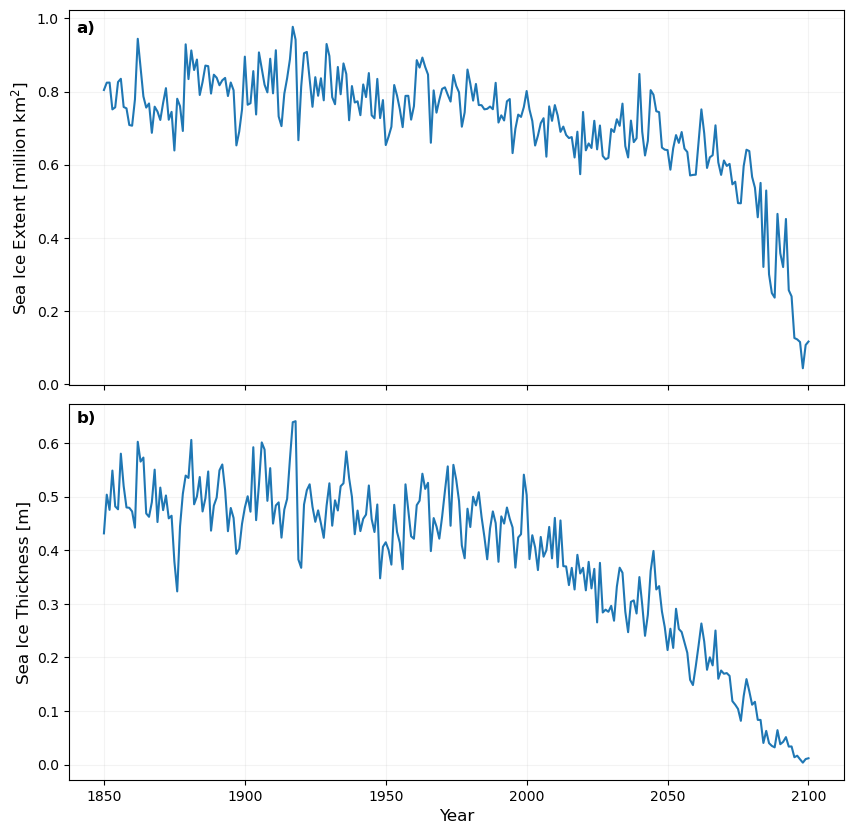

Execution time:  0.0 hours, 0.0 minutes, 1.2858543395996094 seconds


In [36]:
start_time = time.time()

march_aice_hist = aice_hist_region.sel(time=slice('1850','2005'))[2::12].sum(('nj', 'ni'))
march_aice_proj = aice_proj_region.sel(time=slice('2006','2100'))[2::12].sum(('nj', 'ni'))
march_aice=xr.concat([march_aice_hist,march_aice_proj], dim='time')

march_aice_lr = aice_lr_region.sel(time=slice('1850','2100'))[2::12].sum(('nj', 'ni'))

march_hi_hist = hi_hist_region.sel(time=slice('1850','2005'))[2::12].mean(('nj', 'ni'))
march_hi_proj = hi_proj_region.sel(time=slice('2006','2100'))[2::12].mean(('nj', 'ni'))
march_hi=xr.concat([march_hi_hist,march_hi_proj], dim='time')



fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
years =np.arange(1850,2101,1)
#yearss =np.arange(1850,2101)

# First plot              
ax[0].plot(years, march_aice, label='HR-CESM')
#ax[0].plot(years, march_aice_lr, label='CESM-LR')
ax[0].set_ylabel('Sea Ice Extent [million km$^2$]', fontsize=12)
#ax[0].legend(loc='upper right')
ax[0].grid(alpha=0.15)
                 
# Second plot         
ax[1].plot(years, march_hi, label='HR-CESM')
ax[1].set_ylabel('Sea Ice Thickness [m]', fontsize=12)
ax[1].grid(alpha=0.15)
#ax[1].legend(loc='upper right')
ax[1].set_xlabel('Year', fontsize=12)

ax[0].text(0.01, 0.94, 'a)',transform=ax[0].transAxes, fontweight='bold', fontsize=12)
ax[1].text(0.01, 0.95, 'b)',transform=ax[1].transAxes, fontweight='bold', fontsize=12)

plt.subplots_adjust(hspace=0.05)
plt.savefig('/storage2/tkyeimiah/Plots/Fig3.jpg', dpi=500, bbox_inches='tight')
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")


### Fig 4

In [37]:
cis_sic_1990_99 = obs_CT_resampled.sel(time=slice('1990', '1999'))
cis_sic_2000_20 = obs_CT_resampled.sel(time=slice('2000', '2020'))

obs_CT_sel=obs_CT_resampled

model_sic_1990_99_=model_sic_1990_99[2::12].mean('time')
model_sic_2000_20_=model_sic_2000_20[2::12].mean('time')
model_sic_2040_60_=model_sic_2040_60[2::12].mean('time')
model_sic_2080_100_=model_sic_2080_100[2::12].mean('time')
cis_sic_1990_99_=cis_sic_1990_99[2::12].mean('time')*100
cis_sic_2000_20_=cis_sic_2000_20[2::12].mean('time')*100

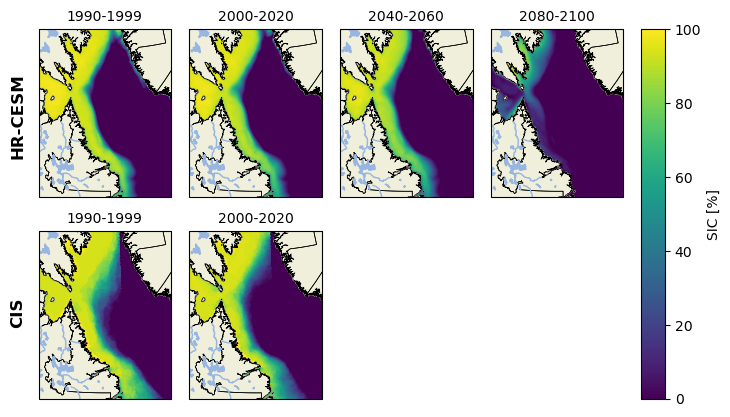

Execution time:  0.0 hours, 0.0 minutes, 49.1900475025177 seconds


In [38]:
#=========sic_region==max========================

fig = plt.figure(figsize=(8,4.8))
sic_data = [model_sic_1990_99_, model_sic_2000_20_, model_sic_2040_60_, model_sic_2080_100_,
                 cis_sic_1990_99_, cis_sic_2000_20_]

#hi_data1 = [model_hi_1990_99, model_hi_2000_20, model_hi_2040_60, model_hi_2080_100]
titles = ['1990-1999', '2000-2020', '2040-2060', '2080-2100', '1990-1999', '2000-2020']


norm = plt.Normalize(0, 100)
cb=cm.ScalarMappable(norm=norm)


x0, x1, y0, y1 =-68,-48,51,67

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i, v in enumerate(sic_data):
#for i in range(3):
    # Create a subplot with the PlateCarree projection
    ax = plt.subplot(2,4, i+1,projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
    ax.set_title(titles[i], fontsize=10)
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5,  zorder=2)
    ax.add_feature(cfeature.LAKES.with_scale('10m'),  zorder=2)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'),  zorder=2)
    ax.set_extent([x0, x1, y0, y1])
    #ax.text(0,1.05,letter[i], transform=ax.transAxes, fontsize=9)
    
   
    if i in [0,1,2,3]:
        contf=ax.contourf(sic_data[i].TLON, sic_data[i].TLAT, sic_data[i], vmin=15,
                          levels=100,transform=ccrs.PlateCarree(), zorder=1)
    if i in [4,5]:
        contf=ax.contourf(sic_data[i].lon, sic_data[i].lat, sic_data[i].fillna(0),vmin=15,levels=100,
                           transform=ccrs.PlateCarree(), zorder=1)
    
    
cbar_ax = fig.add_axes([0.9, 0.11, 0.03, 0.77])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical',label='SIC [%]')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIC [%]', fontsize=10)  

name=['HR-CESM','CIS']
x=[0.13,0.13]
y=[0.7,0.29]
for i in range (2):
    fig.text(x[i],y[i], name[i], fontweight='bold',va='bottom', ha='center', rotation='vertical',
             rotation_mode='anchor',fontsize=12)
plt.subplots_adjust(wspace=-0.1)
#plt.subplots_adjust(hspace=0.7)
plt.savefig('/storage2/tkyeimiah/Plots/Fig4.jpg',dpi=500, bbox_inches='tight')
plt.show()


end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")
    
    
    

plt.show()

### Fig 5

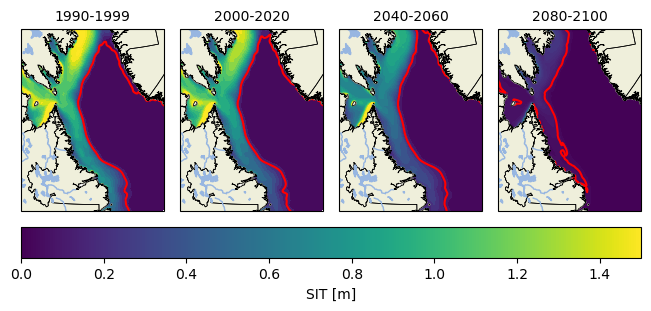

Execution time:  0.0 hours, 0.0 minutes, 57.015347957611084 seconds


In [39]:
#=========sic_region==max========================

fig = plt.figure(figsize=(8,2.4))
sic_data = [model_sic_1990_99_, model_sic_2000_20_, model_sic_2040_60_, model_sic_2080_100_]

hi_data1 = [model_hi_1990_99, model_hi_2000_20, model_hi_2040_60, model_hi_2080_100]
titles = ['1990-1999', '2000-2020', '2040-2060', '2080-2100',]

global_min = np.min([np.nanmin(data.max('time').values) for data in hi_data1])
#global_max = np.max([np.nanmax(data.max('time').values) for data in hi_data1])
norm = plt.Normalize(vmin=global_min, vmax=1.5)
cb=cm.ScalarMappable(norm=norm)

x0, x1, y0, y1 =-68,-48,51,67
  
# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i, v in enumerate(sic_data):
#for i in range(3):
    # Create a subplot with the PlateCarree projection
    ax = plt.subplot(1,4, i+1,projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
    ax.set_title(titles[i], fontsize=10)
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5,  zorder=2)
    ax.add_feature(cfeature.LAKES.with_scale('10m'),  zorder=2)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'),  zorder=2)
    ax.set_extent([x0, x1, y0, y1])
    #ax.text(0,1.05,letter[i], transform=ax.transAxes, fontsize=9)
    
   
    ax.contourf(hi_data1[i].TLON, hi_data1[i].TLAT, hi_data1[i][2::12].mean('time'),levels=45,
                norm=norm, transform=ccrs.PlateCarree(), zorder=1)
    ax.contour(sic_data[i].TLON, sic_data[i].TLAT, sic_data[i],levels=[15],norm=norm,colors='red',linewidth=5,
               transform=ccrs.PlateCarree(), zorder=1)
    #if i in [4,5]:
        #contf=ax.contourf(sic_data[i].lon, sic_data[i].lat, sic_data[i],
                          #levels=45, norm=norm, transform=ccrs.PlateCarree())
    
    
cbar_ax = fig.add_axes([0.125, -0.08, 0.775, 0.13])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='horizontal', label='SIT [m]')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIT [m]', fontsize=10)  


plt.subplots_adjust(wspace=0.11)
#plt.subplots_adjust(hspace=0.7)
plt.savefig('/storage2/tkyeimiah/Plots/Fig5.jpg',dpi=500, bbox_inches='tight')
plt.show()


end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")
    
    
    

plt.show()

### Fig 6

In [40]:
hi_month_1990_2005=hi_hist_region.sel(time=slice('1990-01-01','2005-12-31'))
hi_month_2006_2020=hi_proj_region.sel(time=slice('2006-01-01','2020-12-31'))
hi_region_1990_2020=xr.concat((hi_month_1990_2005,hi_month_2006_2020 ), dim='time')
hi_months=hi_region_1990_2020.groupby('time.month').mean('time')

In [41]:
#plot for article
sic_month_1990_2005 = aice_hist_region_.sel(time=slice('1990-01-01','2005-12-31'))
sic_month_2006_2020 = aice_proj_region_.sel(time=slice('2006-01-01','2020-12-31'))
sic_region_1990_2020= xr.concat([sic_month_1990_2005, sic_month_2006_2020], dim='time')
sic_months=sic_region_1990_2020.groupby('time.month').mean('time')

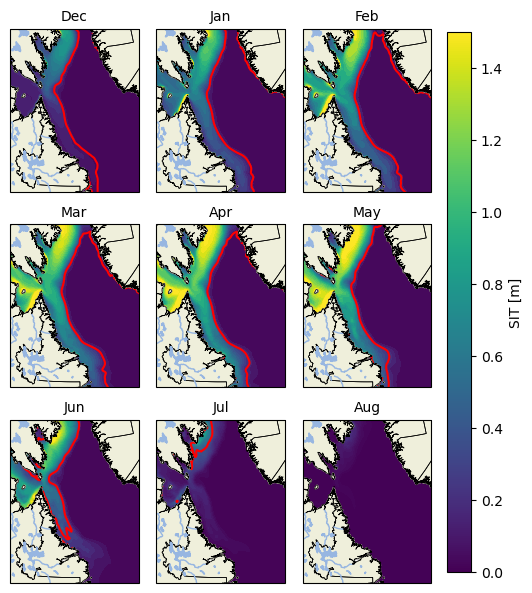

In [42]:
fig = plt.figure(figsize=(6, 7.2))

selected_data= [hi_months[11], hi_months[0], hi_months[1], hi_months[2], hi_months[3], hi_months[4], hi_months[5], hi_months[6],hi_months[7]]
selected_data1=[sic_months[11],sic_months[0],sic_months[1],sic_months[2],sic_months[3], sic_months[4], sic_months[5],sic_months[6],sic_months[7]]


titles = ['Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug']
#name=['a)','b)','c)','d)','e)','f)','g)','h)','i)']

global_min = np.min([np.nanmin(data.values) for data in selected_data])
global_max = np.max([np.nanmax(data.values) for data in selected_data])
norm = plt.Normalize(vmin=global_min, vmax=1.5)
cb=cm.ScalarMappable(norm=norm)

x0, x1, y0, y1 =-68,-48,51,67


# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i, v in enumerate(selected_data):
    ax = plt.subplot(3,3, i+1,projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
    
    ax.set_title(titles[i], fontsize=10)
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5,  zorder=2)
    ax.add_feature(cfeature.LAKES.with_scale('10m'),  zorder=2)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'),  zorder=2)
    #ax.add_feature(cfeature.BORDERS,  zorder=2)
    
    
    ax.set_extent([x0, x1, y0, y1])
    #ax.text(0,1.05,name[i], transform=ax.transAxes, fontsize=10)
    ax.contourf(selected_data[i].TLON, selected_data[i].TLAT, selected_data[i], levels=45, norm=norm,
                   transform=ccrs.PlateCarree(), )
    ax.contour(selected_data1[i].TLON, selected_data1[i].TLAT, selected_data1[i], levels=[15], norm=norm, colors='red',
               linewidth=5, transform=ccrs.PlateCarree(), zorder=1)
    
cbar_ax = fig.add_axes([0.89, 0.125, 0.04, 0.75])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIT [m]', fontsize=10)  

plt.subplots_adjust(wspace=-0.15)
plt.savefig('/storage2/tkyeimiah/Plots/Fig6.jpg',dpi=500, bbox_inches='tight')
plt.show()

### Fig 7

In [43]:
model_SIE_hist =aice_hist_region.sel(time=slice('1990-01-01','2005-12-31'))
model_SIE_proj =aice_proj_region.sel(time=slice('2006-01-01','2020-12-31'))
model_SIE= xr.concat([model_SIE_hist, model_SIE_proj], dim='time')

obs_SIE=obs_CT_region.sel(time=slice('1990-01-01','2020-12-31'))

model_SIE_march=model_SIE[2::12].sum(('nj', 'ni'))
obs_SIE_march=obs_SIE[2::12].sum(['rlat','rlon'])
model_SIE_march_lr = aice_lr_region.sel(time=slice('1990-01-01','2020-12-31'))[2::12].sum(('nj', 'ni'))

In [44]:
obs_SIE_march

<xarray.DataArray (time: 31)>
array([1.0321423 , 0.91988359, 0.88082156, 0.99801854, 0.91150692,
       0.87890708, 0.79725311, 0.80831114, 0.78588518, 0.77936666,
       0.84076833, 0.80432339, 0.76216806, 0.7400009 , 0.66682084,
       0.69894935, 0.59213104, 0.74037295, 0.92868838, 0.84891249,
       0.66619557, 0.71401774, 0.9210548 , 0.69922861, 0.86165184,
       0.85631848, 0.82483082, 0.77322292, 0.79302201, 0.71980168,
       0.96913573])
Coordinates:
  * time     (time) datetime64[ns] 1990-03-31 1991-03-31 ... 2020-03-31

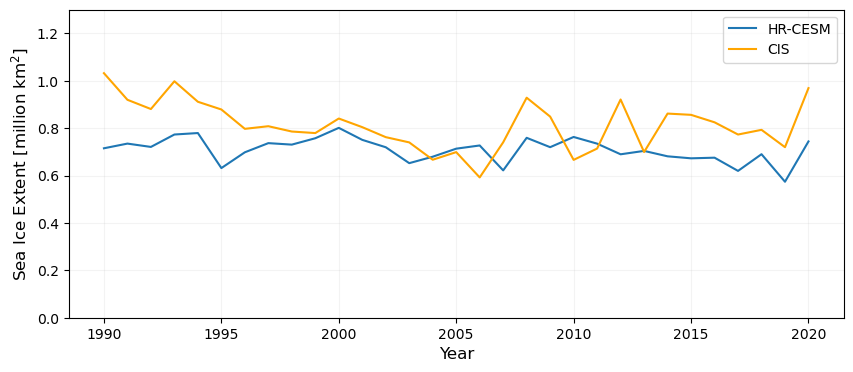

Execution time:  0.0 hours, 0.0 minutes, 0.5326778888702393 seconds


In [45]:
#Plot of the obs and model from 1990 to 2018
fig, ax=plt.subplots(figsize=(10,4))
start_time=time.time()

ax.plot(np.arange(1990,2021), model_SIE_march, label='HR-CESM', color='tab:blue', )
ax.plot(np.arange(1990,2021), obs_SIE_march, color='orange', label='CIS')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Sea Ice Extent [million km$^2$]', fontsize=12)
ax.set_ylim(0,1.3)
ax.legend()
ax.grid(alpha=0.15)
#plt.xlim(1990,2021)

plt.savefig('/storage2/tkyeimiah/Plots/Fig7-old.jpg',dpi=500, bbox_inches='tight') 
plt.show()


end_time=time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

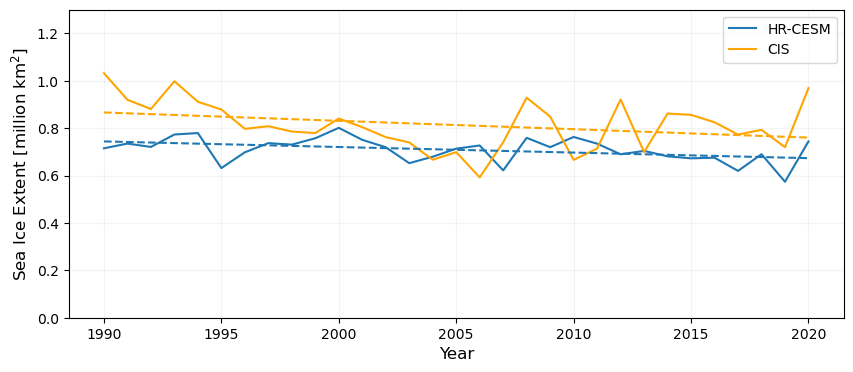

Execution time:  0.0 hours, 0.0 minutes, 0.5683004856109619 seconds


In [46]:
fig, ax = plt.subplots(figsize=(10, 4))
start_time = time.time()

# Your existing data plotting
ax.plot(np.arange(1990, 2021), model_SIE_march, label='HR-CESM', color='tab:blue')
ax.plot(np.arange(1990, 2021), obs_SIE_march, color='orange', label='CIS')

# Calculating and plotting the slope for model_SIE_march
slope, intercept = np.polyfit(np.arange(1990, 2021), model_SIE_march, 1)
ax.plot(np.arange(1990, 2021), slope*np.arange(1990, 2021) + intercept, color='tab:blue', linestyle='--')

# Calculating and plotting the slope for obs_SIE_march
slope, intercept = np.polyfit(np.arange(1990, 2021), obs_SIE_march, 1)
ax.plot(np.arange(1990, 2021), slope*np.arange(1990, 2021) + intercept, color='orange', linestyle='--')

# Setting labels and legend
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Sea Ice Extent [million km$^2$]', fontsize=12)
ax.set_ylim(0,1.3)
ax.legend()
#ax.set_title('March SIE over the Labrado Coast')
ax.grid(alpha=0.15)

# Save and show the plot
plt.savefig('/storage2/tkyeimiah/Plots/Fig7.jpg', dpi=500, bbox_inches='tight')
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")


In [47]:
def rmse(predictions, targets):
    differences = predictions - targets                       # the differences between prediction and observation
    differences_squared = differences ** 2                    # square the differences
    mean_of_differences_squared = differences_squared.mean()  # mean of the squared differences
    rmse_val = np.sqrt(mean_of_differences_squared)           # square root of the mean of the squared differences
    return rmse_val

In [48]:
HR_rmse=rmse(model_SIE_march.values,obs_SIE_march.values)
LR_rmse=rmse(model_SIE_march_lr.values,obs_SIE_march.values)
print(HR_rmse,LR_rmse)

0.14564158602328406 0.17088185479540305


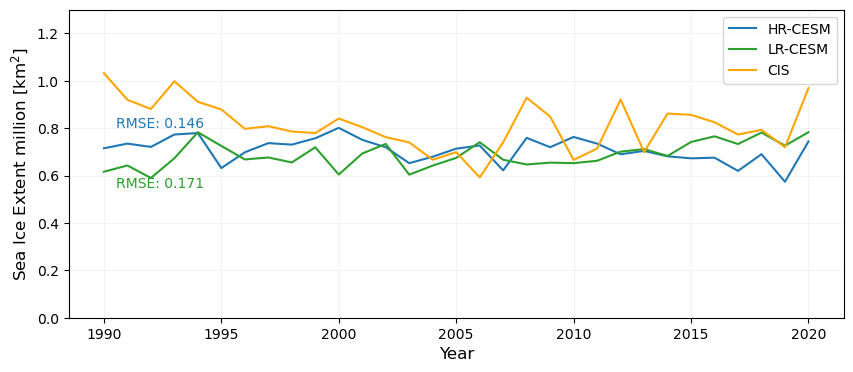

Execution time:  0.0 hours, 0.0 minutes, 0.4184739589691162 seconds


In [49]:
#Plot of the obs and model from 1990 to 2018
fig, ax=plt.subplots(figsize=(10,4))
start_time=time.time()

ax.plot(np.arange(1990,2021), model_SIE_march, color='tab:blue', label='HR-CESM')
ax.plot(np.arange(1990,2021), model_SIE_march_lr,color='tab:green', label='LR-CESM')
ax.plot(np.arange(1990,2021), obs_SIE_march, color='orange', label='CIS')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Sea Ice Extent million [km$^2$]', fontsize=12)
ax.set_ylim(0,1.3)
ax.legend()

# Add RMSE to the plot
ax.text(1990.5, 0.8, f'RMSE: {HR_rmse:.3f}', color='tab:blue', fontsize=10)  # Adjust position and values as needed
ax.text(1990.5, 0.55, f'RMSE: {LR_rmse:.3f}', color='tab:green', fontsize=10)  # Adjust position and values as needed

ax.grid(alpha=0.15)

plt.savefig('/storage2/tkyeimiah/Plots/Fig11.jpg',dpi=300, bbox_inches='tight') 
plt.show()

end_time=time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

### Fig 8

In [50]:
#----------
obs_CT_1990_99 = obs_CT_sel.sel(time=slice('1990', '1999'))
obs_CT_2000_09 = obs_CT_sel.sel(time=slice('2000', '2009'))
obs_CT_2010_20 = obs_CT_sel.sel(time=slice('2010', '2020'))

#----------
model_CT_1990_99 = model_CT_sel.sel(time=slice('1990', '1999'))
model_CT_2000_09 = model_CT_sel.sel(time=slice('2000', '2009'))
model_CT_2010_20 = model_CT_sel.sel(time=slice('2010', '2020'))

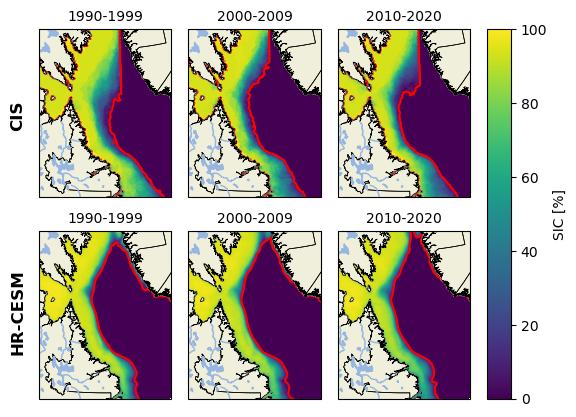

Execution time:  0.0 hours, 0.0 minutes, 40.17632985115051 seconds


In [51]:
start_time = time.time()

# Create a figure with two# Create a figure with two subplots
fig = plt.figure(figsize=(6,4.8))

selected_data=[obs_CT_1990_99,obs_CT_2000_09, obs_CT_2010_20, model_CT_1990_99, model_CT_2000_09,model_CT_2010_20]
titles=['1990-1999', '2000-2009','2010-2020','1990-1999', '2000-2009','2010-2020']
#letter=['a)','b)','c)','d)','e)','f)']
norm = plt.Normalize(0,100)
cb=cm.ScalarMappable(norm=norm)


x0, x1, y0, y1 =-68,-48,51,67

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i, v in enumerate(selected_data):
#for i in range(3):
    # Create a subplot with the PlateCarree projection
    ax = plt.subplot(2,3, i+1,projection=ccrs.AlbersEqualArea(central_longitude=c_lon, 
                                                              central_latitude=c_lat,standard_parallels=(y0, y1)))
    ax.set_title(titles[i], fontsize=10)
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5,  zorder=2)
    ax.add_feature(cfeature.LAKES.with_scale('10m'),  zorder=2)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'),  zorder=2)
    ax.set_extent([x0, x1, y0, y1])
    #ax.text(0,1.05,letter[i], transform=ax.transAxes, fontsize=9)
    
    if i in [0,1,2]:
        ax.contourf(selected_data[i].lon, selected_data[i].lat, selected_data[i][2::12].mean('time').fillna(0)*100,
                      vmin=15,levels=100, transform=ccrs.PlateCarree(), zorder=1)
        ax.contour(selected_data[i].lon, selected_data[i].lat, selected_data[i][2::12].mean('time').fillna(0)*100, 
                   levels=[15],  colors='red', linewidth=5, transform=ccrs.PlateCarree(), zorder=1)
    
    if i in [3,4,5]:
        ax.contourf(selected_data[i].TLON, selected_data[i].TLAT, selected_data[i][2::12].mean('time'),
                     vmin=15,levels=100,transform=ccrs.PlateCarree(), zorder=1)
        ax.contour(selected_data[i].TLON, selected_data[i].TLAT, selected_data[i][2::12].mean('time'), 
                   levels=[15], colors='red',linewidth=5, transform=ccrs.PlateCarree(), zorder=1)

    
cbar_ax = fig.add_axes([0.9, 0.11, 0.04, 0.77])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical',label='SIC (%)')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIC [%]', fontsize=10)  

name=['CIS', 'HR-CESM']
x=[0.13,0.13]
y=[0.7,0.29]
for i in range (2):
    fig.text(x[i],y[i], name[i], fontweight='bold',va='bottom', ha='center', rotation='vertical',
             rotation_mode='anchor',fontsize=12)
plt.subplots_adjust(wspace=-0.1)
#plt.subplots_adjust(hspace=0.7)
plt.savefig('/storage2/tkyeimiah/Plots/Fig8.jpg',dpi=500, bbox_inches='tight')
plt.show()



end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

### Fig 9

In [52]:
obs_months=obs_CT_sel.groupby('time.month').mean('time')
model_months=model_CT_sel.groupby('time.month').mean('time')

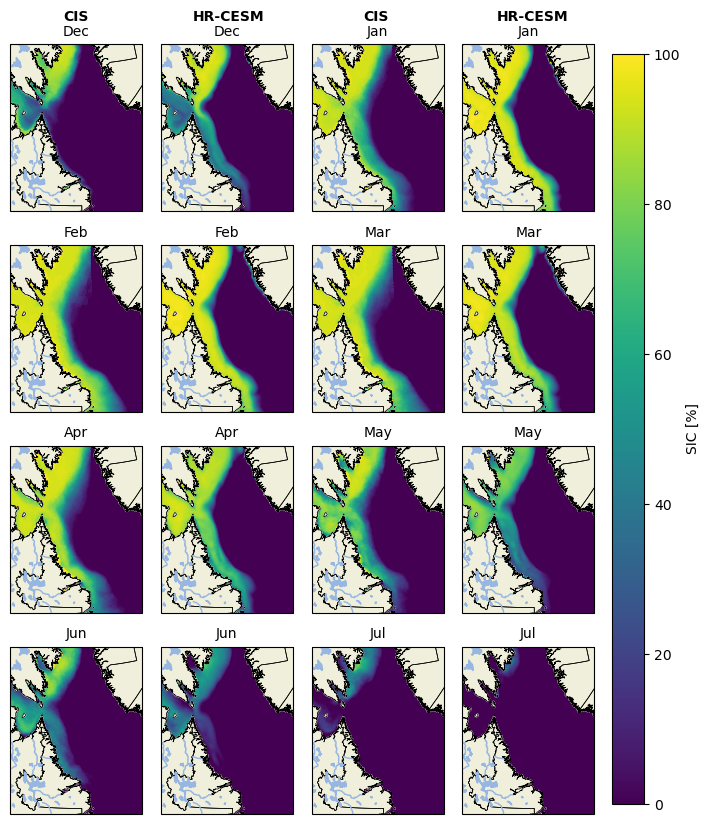

Execution time:  0.0 hours, 1.0 minutes, 34.60948443412781 seconds


In [53]:
start_time = time.time()
#fig = plt.figure(figsize=(8, 4.8))
fig = plt.figure(figsize=(8,10))
obs_data=[obs_months[-1], obs_months[0],obs_months[1],obs_months[2],obs_months[3],obs_months[4],
          obs_months[5],obs_months[6]]

model_data=[model_months[-1],model_months[0],model_months[1],model_months[2],model_months[3],model_months[4],
            model_months[5],model_months[6]]

titles = ['Dec','Jan','Feb','Mar','Apr','May','Jun','Jul',]
#name=['a)','c)','e)','g)','i)','k)','m)','o)','q)']
#name1=['b)','d)','f)','h)','j)','l)','n)','p)','r)']

norm = plt.Normalize(0, 100)
cb=cm.ScalarMappable(norm=norm)

x0, x1, y0, y1 =-68,-48,51,67

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i in range(16):
    index = i // 2 
    
    if i % 2 == 0:
        ax = plt.subplot(4, 4, i+1, projection=ccrs.AlbersEqualArea(central_longitude=c_lon,
                                                                     central_latitude=c_lat,
                                                                     standard_parallels=(y0, y1)))
        ax.set_title(titles[index], fontsize=10)
        ax.add_feature(cfeature.LAND, zorder=2)
        ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, zorder=2)
        ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=2)
        ax.add_feature(cfeature.RIVERS.with_scale('10m'), zorder=2)
        ax.set_extent([x0, x1, y0, y1])
        ax.contourf(obs_data[index].lon, obs_data[index].lat, obs_data[index].fillna(0)*100, vmin=15,levels=100,
                    transform=ccrs.PlateCarree())
        #ax.text(0,1.05,name[index], transform=ax.transAxes, fontsize=10)
        
    else:
        ax = plt.subplot(4, 4, i+1, projection=ccrs.AlbersEqualArea(central_longitude=c_lon,
                                                                     central_latitude=c_lat,
                                                                     standard_parallels=(y0, y1)))
        if index < len(model_data):
            ax.set_title(titles[index], fontsize=10)
            ax.add_feature(cfeature.LAND, zorder=2)
            ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, zorder=2)
            ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=2)
            ax.add_feature(cfeature.RIVERS.with_scale('10m'), zorder=2)
            ax.set_extent([x0, x1, y0, y1])
            ax.contourf(model_data[index].TLON, model_data[index].TLAT, model_data[index], levels=100,
                        vmin=15, transform=ccrs.PlateCarree(), zorder=1)
            #ax.text(0,1.05,name1[index], transform=ax.transAxes, fontsize=10)

cbar_ax = fig.add_axes([0.9, 0.12, 0.04, 0.75])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical',label='SIC [%]')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('SIC [%]', fontsize=10)

name=['CIS', 'HR-CESM','CIS', 'HR-CESM']
x=[0.23, 0.42, 0.605, 0.8]
y=[0.9,0.9,0.9,0.9]
for i in range (4):
    fig.text(x[i],y[i], name[i], fontweight='bold',va='bottom', ha='center', rotation='horizontal',
             rotation_mode='anchor',fontsize=10)


plt.subplots_adjust(wspace=-0.1)
plt.savefig('/storage2/tkyeimiah/Plots/Fig9.jpg',dpi=500, bbox_inches='tight')
plt.show()



end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

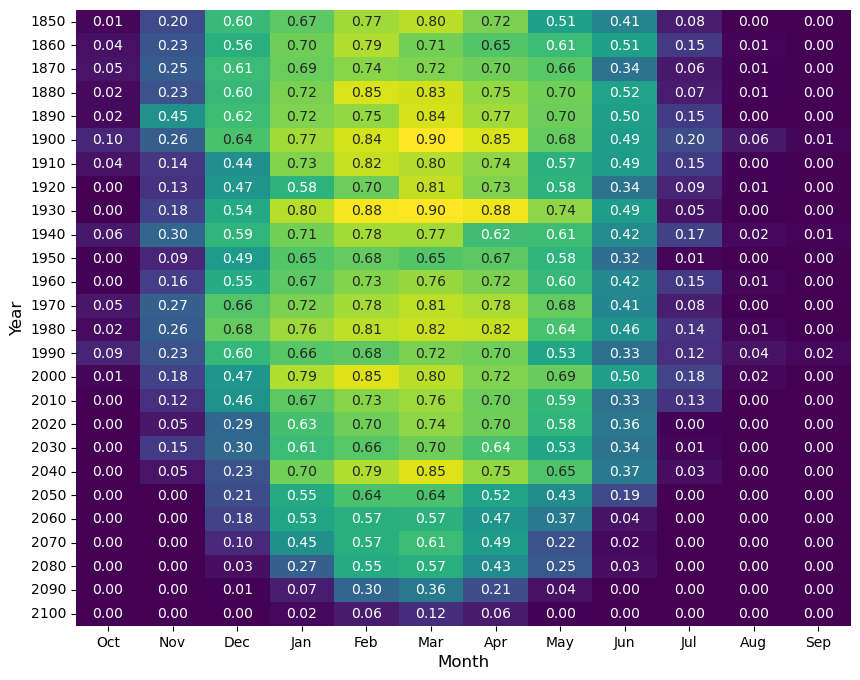

In [54]:
# Convert this DataArray to a DataFrame
aice1 = aice_hist_region.sel(time=slice('1850-01-01','2005-12-31'))
aice2 = aice_proj_region.sel(time=slice('2006-01-01','2100-12-31'))
aice3 = xr.concat([aice1, aice2], dim='time') 

ds_mean = aice3.sum(dim=['nj', 'ni'], skipna=True)
df = ds_mean.to_dataframe(name='SIE')

# Reset the index so that 'time' becomes a column
df.reset_index(inplace=True)

# Extract the year and month from the 'time' column
df['Year'] = [date.year for date in df['time']]
df['Month'] = [date.month for date in df['time']]

# Map numeric month to month name
month_dict = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 
              6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 
              11: 'Nov', 12: 'Dec'}

df['Month'] = df['Month'].map(month_dict)

# Define custom sorting order for the months
custom_order = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar',
                'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']

# Convert 'month' to categorical data type with custom order
df['Month'] = pd.Categorical(df['Month'], categories=custom_order, ordered=True)

# Filter rows for the specified years
selected_years = np.arange(1850,2101,10)
df_all = df[df['Year'].isin(selected_years)]

# Create a pivot table with 'year' as rows, 'month' as columns, and mean 'aice' as values
pivot_df = df_all.pivot('Year', 'Month', 'SIE')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df,  cmap="viridis", annot=True, fmt='.2f', cbar=False)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Year', fontsize=12)
#cbar_kws={'label':'SIE [million km$^2$]'}
plt.savefig('/storage2/tkyeimiah/Plots/Fig10.jpg',dpi=500, bbox_inches='tight')
plt.show()

In [55]:
# heat_map function

def heat_map(data, source):
    if source=='model':
        ds_mean = data.sum(dim=['nj', 'ni'], skipna=True)
        df = ds_mean.to_dataframe(name='SIE')
    elif source=='obs':
        ds_mean = data.sum(dim=['rlat', 'rlon'], skipna=True)
        df = ds_mean.to_dataframe(name='SIE')

    # Reset the index so that 'time' becomes a column
    df.reset_index(inplace=True)

    # Extract the year and month from the 'time' column
    df['Year'] = [date.year for date in df['time']]
    df['Month'] = [date.month for date in df['time']]

    # Map numeric month to month name
    month_dict = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                  7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

    df['Month'] = df['Month'].map(month_dict)
    
    # Define custom sorting order for the months
    custom_order = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar','Apr',
                    'May', 'Jun', 'Jul', 'Aug', 'Sep']

    # Convert 'month' to categorical data type with custom order
    df['Month'] = pd.Categorical(df['Month'], categories=custom_order, ordered=True)

    # Filter rows for the specified years
    selected_years = np.arange(1990,2021,1)
    df_all = df[df['Year'].isin(selected_years)]

    # Create a pivot table with 'year' as rows, 'month' as columns, and mean 'aice' as values
    pivot_df = df_all.pivot('Year', 'Month', 'SIE')
    return pivot_df

In [56]:
#using the function
model_SIE_pivot=heat_map(model_SIE, 'model')
obs_SIE_pivot=heat_map(obs_SIE, 'obs')

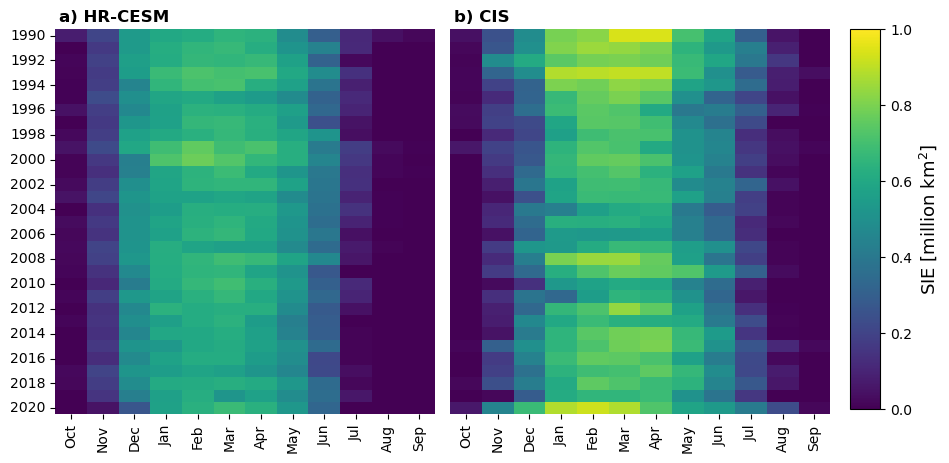

In [57]:
import matplotlib.colors as mcolors
import matplotlib.colorbar as mcolorbar
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5),  gridspec_kw={'width_ratios':[1,1]})

g1 = sns.heatmap(model_SIE_pivot,  vmax=1.1, cmap="viridis", cbar=False, ax=ax1)
g1.set_ylabel('')
g1.set_xlabel('')
g1.text(0.01, 1.02, 'a) HR-CESM',transform=ax1.transAxes, fontweight='bold', fontsize=12)


g2 = sns.heatmap(obs_SIE_pivot,  vmax=1.1,cbar=False, cmap="viridis", ax=ax2)
#colorbar = g2.collections[0].colorbar
#colorbar.ax.yaxis.label.set_size(13)  # Set the font size here
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])
g2.text(0.01, 1.02, 'b) CIS',transform=ax2.transAxes, fontweight='bold',fontsize=12)

for ax in [g1,g2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=90)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)

axcb = fig.add_axes([0.92, 0.12, 0.03, 0.76])

# Create a colormap and a normalize object
cmap = sns.color_palette("viridis", as_cmap=True)
norm = mcolors.Normalize(vmin=0, vmax=1)

# Create the colorbar
cb1 = mcolorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='vertical',)
cb1.set_label('SIE [million km$^2$]')
cb1.ax.yaxis.label.set_size(13)    
    
plt.subplots_adjust(wspace=0.04)  
plt.savefig('/storage2/tkyeimiah/Plots/Fig10-b.jpg',dpi=500, bbox_inches='tight')
plt.show()

In [58]:
y

[0.9, 0.9, 0.9, 0.9]

## Dynamic + Thermodynamic // LandFast Analysis

#### HR-CESM

In [59]:
start_time=time.time()

path = '/storage2/tkyeimiah'


daidtd_dh = xr.open_dataset(path+'/iHESP/EM1/hist/daidtd_hist/daidtd_hist.nc')
daidtd_dp = xr.open_dataset(path+'/iHESP/EM1/proj/daidtd_proj/daidtd_proj.nc')


daidtt_dh = xr.open_dataset(path+'/iHESP/EM1/hist/daidtt_hist/daidtt_hist.nc')
daidtt_dp = xr.open_dataset(path+'/iHESP/EM1/proj/daidtt_proj/daidtt_proj.nc')


end_time=time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)

print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

Execution time:  0.0 hours, 0.0 minutes, 0.6330742835998535 seconds


In [60]:
daidtd_hist=shift_month(daidtd_dh['daidtd'])
daidtd_proj=shift_month(daidtd_dp['daidtd'])

daidtt_hist=shift_month(daidtt_dh['daidtt'])
daidtt_proj=shift_month(daidtt_dp['daidtt'])

In [ ]:
# Define the Labrador coast boundaries (replace these with your desired region)
lon_min, lon_max =287, 315 #73W & 45W
lat_min, lat_max =51,69


# Create a mask for Labrador coast 
mask_daidtd_hist = ((daidtd_hist.TLAT >= lat_min) & (daidtd_hist.TLAT <= lat_max) &
                    (daidtd_hist.TLON >= lon_min) & (daidtd_hist.TLON <= lon_max))

mask_daidtd_proj = ((daidtd_proj.TLAT >= lat_min) & (daidtd_proj.TLAT <= lat_max) &
                    (daidtd_proj.TLON >= lon_min) & (daidtd_proj.TLON <= lon_max))

mask_daidtt_hist = ((daidtt_hist.TLAT >= lat_min) & (daidtt_hist.TLAT <= lat_max) &
                    (daidtt_hist.TLON >= lon_min) & (daidtt_hist.TLON <= lon_max))

mask_daidtt_proj = ((daidtt_proj.TLAT >= lat_min) & (daidtt_proj.TLAT <= lat_max) &
                    (daidtt_proj.TLON >= lon_min) & (daidtt_proj.TLON <= lon_max))

# Apply the mask to the aice variable
daidtd_hist_region =daidtd_hist.where(mask_daidtd_hist, drop=True)
daidtd_proj_region =daidtd_proj.where(mask_daidtd_proj, drop=True)
daidtt_hist_region =daidtt_hist.where(mask_daidtt_hist, drop=True)
daidtt_proj_region =daidtt_proj.where(mask_daidtt_proj, drop=True)

#### Formula

The material derivative formula, often used in fluid dynamics, is given by:

$$ \frac{D\mathbf{a}}{Dt} = \frac{\partial \mathbf{a}}{\partial t} + (\mathbf{u} \cdot \nabla)\mathbf{a} $$

Here, 
- \[ $\frac{D\mathbf{a}}{Dt}$ \] represents the total derivative / resultant of the sea ice concentration \( $\mathbf{a}$ \).
- \[ $\frac{\partial \mathbf{a}}{\partial t}$ \] is the local derivative (thermodynamic processes of the sea ice \( $\mathbf{daidtt}$ \)).
- \[ $(\mathbf{u} \cdot \nabla)\mathbf{a}$ \] is the convective or advectivie derivative (dynamic processes of sea ice \( $\mathbf{daidtd}$ \)).

Thus,

$$ \frac{D\mathbf{a}}{Dt} = \mathbf{daidtt} + \mathbf{daidtd} $$


In [ ]:
DaDt_hist = daidtd_hist_region + daidtt_hist_region
DaDt_proj = daidtd_proj_region + daidtt_proj_region

In [ ]:
DaDt_1990_99 = DaDt_hist.sel(time=slice('1990-01-01','1999-12-31'))
DaDt_2000_05 = DaDt_hist.sel(time=slice('2000-01-01','2005-12-31'))
DaDt_2006_20 = DaDt_proj.sel(time=slice('2006-01-01','2020-12-31'))
DaDt_2000_20 = xr.concat([DaDt_2000_05, DaDt_2006_20], dim='time')

In [ ]:
DaDt_1990_99_monthly = DaDt_1990_99.groupby('time.month').mean('time').mean(('nj','ni'))
DaDt_2000_20_monthly = DaDt_2000_20.groupby('time.month').mean('time').mean(('nj','ni'))

In [ ]:
# Set xticks to represent months from January to December

start_time = time.time()

fig,ax=plt.subplots(figsize=(10,4))
all_data_a = [DaDt_1990_99_monthly,DaDt_2000_20_monthly]
labels = ['1990-1999', '2000-2020']

for i in range(len(all_data_a)):
    
  
    ax.plot(np.arange(12) ,all_data_a[i], label=labels[i],)
    

plt.xticks(np.arange(0,12), ['Jan','Feb','Mar','Apr','May','Jun', 'Jul','Aug','Sep', 'Oct','Nov','Dec'])
plt.hlines(y=0, xmin=0, xmax=11, color='black')
plt.legend()
plt.xlabel('Month')
plt.ylabel('Sea Ice Concetration [%/day]')
plt.grid(alpha=0.15)
plt.xlim(0,11)
plt.tight_layout()
plt.savefig('/storage2/tkyeimiah/Plots/new1.jpg', dpi=300, bbox_inches='tight')

plt.show()


end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

#### CIS Fast ice

In [ ]:
start_time=time.time()
FA_data=xr.open_dataset(path+'/Obs/CIS/CIS_combined/FA_all_combined.nc')
end_time=time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)

print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

In [ ]:
#selecting FA variable
FA=FA_data['FA']

In [ ]:
# Create the fast ice mask
fast_ice_mask = FA == 8  # Fast ice code is 8

# Apply the fast ice mask to the SIC variable
#obs_FA_resampled = CT1_resampled.where(fast_ice_mask)

obs_FA_resampled = obs_CT.where(fast_ice_mask)

In [ ]:
# Create a mask for Labrador coast 
lat_min, lat_max = 51, 69
lon_min, lon_max =-73, -45
mask_lab = ((obs_FA_resampled.lat>= lat_min) & (obs_FA_resampled.lat <= lat_max) &
            (obs_FA_resampled.lon >= lon_min) & (obs_FA_resampled.lon<= lon_max))
obs_fast_ice_lab =obs_FA_resampled.where(mask_lab, drop=True)

In [ ]:
#calculation
obs_fast_ice=(obs_fast_ice_lab * obs_area_region)/1e6

In [ ]:
obs_fast_ice_1990_99 = obs_fast_ice.sel(time=slice('1990-01-01','1999-12-31'))
obs_fast_ice_2000_20 = obs_fast_ice.sel(time=slice('2000-01-01','2020-12-31'))

In [ ]:
obs_fast_ice_1990_99_monthly = obs_fast_ice_1990_99.groupby('time.month').mean('time').sum(['rlat','rlon'])
obs_fast_ice_2000_20_monthly = obs_fast_ice_2000_20.groupby('time.month').mean('time').sum(['rlat','rlon'])

In [ ]:
# Set xticks to represent months from January to December

start_time = time.time()

fig,ax=plt.subplots(figsize=(10,4))
all_data_a = [obs_fast_ice_1990_99_monthly, obs_fast_ice_2000_20_monthly]
labels = ['1990-1999', '2000-2020']

for i in range(len(all_data_a)):
    
    linestyle = '--'  # Default linestyle
    ax.plot(np.arange(12) ,all_data_a[i], label=labels[i], linestyle=linestyle)
    

plt.xticks(np.arange(0,12), ['Jan','Feb','Mar','Apr','May','Jun', 'Jul','Aug','Sep', 'Oct','Nov','Dec'])
plt.legend()
plt.xlabel('Month')
plt.ylabel('Fast Ice Area [million km$^2$]')
plt.grid(alpha=0.15)
plt.xlim(0,11)
plt.tight_layout()
plt.savefig('/storage2/tkyeimiah/Plots/new1.jpg', dpi=300, bbox_inches='tight')

plt.show()


end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")

In [ ]:
# total tendency
DaDt_hist_=DaDt_hist.sel(time=slice('1990-01-01','2005-12-31'))
DaDt_proj_=DaDt_proj.sel(time=slice('2006-01-01','2020-12-31'))
DaDt_sel= xr.concat([DaDt_hist_, DaDt_proj_], dim='time')
DaDt_months=DaDt_sel.groupby('time.month').mean('time')

#obs fast ice
obs_fast_ice_months=obs_fast_ice_lab.groupby('time.month').mean('time')

In [ ]:
start_time = time.time()
#fig = plt.figure(figsize=(8, 4.8))
fig = plt.figure(figsize=(8,10))
obs_data=[obs_fast_ice_months[-1], obs_fast_ice_months[0],obs_fast_ice_months[1],obs_fast_ice_months[2],obs_fast_ice_months[3],
          obs_fast_ice_months[4], obs_fast_ice_months[5], obs_fast_ice_months[6]]

model_data=[DaDt_months[-1],DaDt_months[0],DaDt_months[1],DaDt_months[2],DaDt_months[3],DaDt_months[4],
            DaDt_months[5],DaDt_months[6]]

titles = ['Dec','Jan','Feb','Mar','Apr','May','Jun','Jul',]
#name=['a)','c)','e)','g)','i)','k)','m)','o)','q)']
#name1=['b)','d)','f)','h)','j)','l)','n)','p)','r)']

norm = plt.Normalize(0, 100)
cb=cm.ScalarMappable(norm=norm)

norm1 = plt.Normalize(-3, 3)
cb1=cm.ScalarMappable(norm=norm1, cmap='coolwarm')

x0, x1, y0, y1 =-68,-48,51,67

# Calculate the central longitude and latitude
c_lon = (x0 + x1) / 2
c_lat = (y0 + y1) / 2
for i in range(16):
    index = i // 2 
    
    if i % 2 == 0:
        ax = plt.subplot(4, 4, i+1, projection=ccrs.AlbersEqualArea(central_longitude=c_lon,
                                                                     central_latitude=c_lat,
                                                                     standard_parallels=(y0, y1)))
        ax.set_title(titles[index], fontsize=10)
        ax.coastlines(alpha=0.03, zorder=11)
        ax.add_feature(cfeature.LAND, alpha=0.2)
        ax.add_feature(cfeature.STATES, alpha=0.003)
        ax.add_feature(cfeature.LAKES.with_scale('10m'),  alpha=0.1, zorder=2)
        ax.add_feature(cfeature.RIVERS.with_scale('10m'),  alpha=0.1, zorder=2)
        ax.set_extent([x0, x1, y0, y1])
        ax.contourf(obs_data[index].lon, obs_data[index].lat, obs_data[index]*100,  norm=norm,
                    transform=ccrs.PlateCarree(), zorder=3)
        #ax.text(0,1.05,name[index], transform=ax.transAxes, fontsize=10)
        
    else:
        ax1 = plt.subplot(4, 4, i+1, projection=ccrs.AlbersEqualArea(central_longitude=c_lon,
                                                                     central_latitude=c_lat,
                                                                     standard_parallels=(y0, y1)))
        if index < len(model_data):
            ax1.set_title(titles[index], fontsize=10)
            ax1.add_feature(cfeature.LAND, zorder=2)
            ax1.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, zorder=2)
            ax1.add_feature(cfeature.LAKES.with_scale('10m'), zorder=2)
            ax1.add_feature(cfeature.RIVERS.with_scale('10m'), zorder=2)
            ax1.set_extent([x0, x1, y0, y1])
            ax1.contourf(model_data[index].TLON, model_data[index].TLAT, model_data[index], levels=15, norm=norm1, cmap='coolwarm',
                         transform=ccrs.PlateCarree(), zorder=1)
            #ax.text(0,1.05,name1[index], transform=ax.transAxes, fontsize=10)

cbar_ax = fig.add_axes([0.9, 0.12, 0.04, 0.75])
cbar=fig.colorbar(cb, cax=cbar_ax, ax=ax, orientation='vertical',label='FIA [million km$^2$]')
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('FIA [million km$^2$]', fontsize=10)

cbar_ax1 = fig.add_axes([1.05, 0.12, 0.04, 0.75])
cbar1=fig.colorbar(cb1, cax=cbar_ax1, ax=ax1, orientation='vertical',label='SIC [%/day]')
cbar1.ax.tick_params(labelsize=10)
cbar1.ax.set_ylabel('SIC [%/day]', fontsize=10)


name=['CIS', 'HR-CESM','CIS', 'HR-CESM']
x=[0.23, 0.42, 0.605, 0.8]
y=[0.9,0.9,0.9,0.9]
for i in range (4):
    fig.text(x[i],y[i], name[i], fontweight='bold',va='bottom', ha='center', rotation='horizontal',
             rotation_mode='anchor',fontsize=10)


plt.subplots_adjust(wspace=-0.1)
#plt.savefig('/storage2/tkyeimiah/Plots/Fig9.jpg',dpi=500, bbox_inches='tight')
plt.show()



end_time = time.time()
elapsed_time = end_time - start_time
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")